In [1]:
import os

os.environ["OMP_NUM_THREADS"] = "10"
os.environ["NUMBA_NUM_THREADS"] = "10"

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from functools import reduce
import pickle
from pathlib import Path
import copy

In [2]:
import sys
sys.path.append("../code/")

In [4]:
from fast_simulators import QAOAFURXSimulatorC
from labs import get_energy_term_indices
from objectives import get_precomputed_optimal_bitstrings, get_precomputed_labs_merit_factors

In [5]:
df = pd.read_json('../qokit/assets/transferred_mean_overlap_0217.json', orient='index')

In [5]:
def probabilities_from_beta_gamma(N, beta, gamma):
    _, offset = get_energy_term_indices(N)
    precomputed_energies_vectorized = -(N**2) / (2 * get_precomputed_labs_merit_factors(N)) - offset
    sim = QAOAFURXSimulatorC(N, precomputed_energies_vectorized)
    sv = sim.simulate_qaoa(gamma, beta)
    return sv.get_norm_squared()

# Just for debugging
def compute_objective_from_probabilities(probabilities):
    precomputed_optimal_bitstrings = get_precomputed_optimal_bitstrings(N)
    precomputed_energies = get_precomputed_labs_merit_factors(N)

    # extract locations of the optimal_bitstrings in 2**N
    bitstring_loc = np.array([reduce(lambda a, b: 2 * a + b, x) for x in precomputed_optimal_bitstrings])
    
    # compute energy
    en = precomputed_energies.dot(probabilities)
    # compute overlap
    overlap = 0
    for i in range(len(bitstring_loc)):
        overlap += probabilities[bitstring_loc[i]]
    return en, 1 - overlap

## TVD

Output of the below cell:
```
22 0.6255718672382471
23 0.6185451644544795
24 0.6152298887125205
25 0.6124827062966421
26 0.6038552310373637
27 0.5980918994959366
```

In [7]:
p = 16
for N in range(22,31):

    row = df[(df["N"] == N) & (df["p"] == p)].squeeze()

    sv = probabilities_from_beta_gamma(row["N"], row["beta"], row["gamma"])

    uniform = np.ones(2**N) / 2**(N)

    print(N, 0.5*sum(np.abs(sv-uniform)))

22 0.6255718672382471
23 0.6185451644544795
24 0.6152298887125205
25 0.6124827062966421
26 0.6038552310373637
27 0.5980918994959366


KeyboardInterrupt: 

## Visualize the distribution

In [8]:
def plot_probabilities_by_energy_level(N, p, df):
    row = df[(df["N"] == N) & (df["p"] == p)].squeeze()
    plot_probabilities_by_energy_level_from_row(N, p, row)
    
def plot_probabilities_by_energy_level_from_row(N, p, row):
    sv = probabilities_from_beta_gamma(row["N"], row["beta"], row["gamma"])
    uniform = np.ones(2**N) / 2**(N)

    precomputed_energies_vectorized = (-(N**2) / (2 * get_precomputed_labs_merit_factors(N))).astype(int)

    assert np.isclose(np.sum(sv[precomputed_energies_vectorized == np.min(precomputed_energies_vectorized)]), row['overlap transferred'])

    probabilities_by_energy_level = []
    probabilities_by_energy_level_uniform = []
    for en in sorted(set(precomputed_energies_vectorized)):
        probabilities_by_energy_level.append(np.sum(sv[precomputed_energies_vectorized == en]))
        probabilities_by_energy_level_uniform.append(np.sum(uniform[precomputed_energies_vectorized == en]))

    assert np.isclose(np.sum(probabilities_by_energy_level), 1)
    assert np.isclose(np.sum(probabilities_by_energy_level_uniform), 1)
    
    print(f"Overlap with top 10: {sum(probabilities_by_energy_level[:10])}")

    plt.plot(probabilities_by_energy_level, label="QAOA")
    plt.plot(probabilities_by_energy_level_uniform, label="Uniform")
    plt.title(f"N={N}, p={p}")
    plt.legend()
    plt.xlabel("Energy level index")
    plt.ylabel("Probability")
    plt.show()

Overlap with top 10: 0.39929288851735667


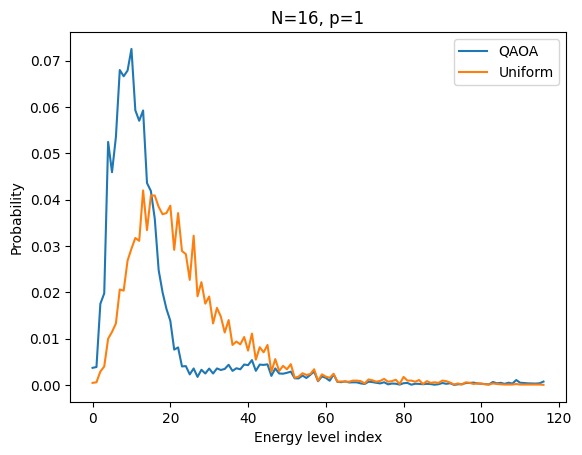

In [29]:
N = 16
p = 1
# df = pd.read_json('../qokit/assets/best_known_QAOA_parameters_wrt_overlap.json', orient='index').rename(columns={'overlap':'overlap transferred'})
df = pd.read_json('../qokit/assets/best_known_QAOA_parameters_wrt_MF.json', orient='index').rename(columns={'overlap':'overlap transferred'})

plot_probabilities_by_energy_level_from_row(N, p, df[(df['p'] == p) & (df['N'] == N)].squeeze())

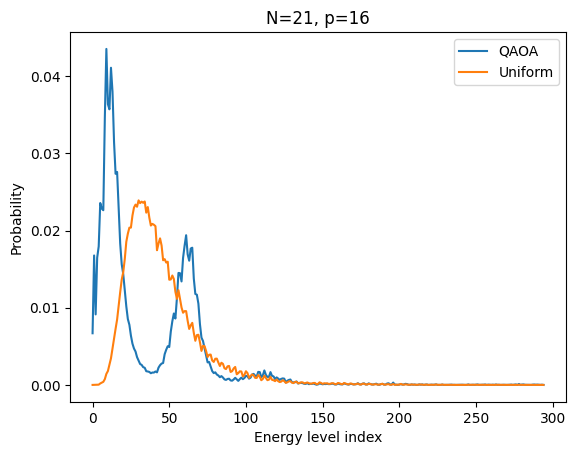

In [50]:
plot_probabilities_by_energy_level(21, 16, df)

In [51]:
df_mf = pd.read_json('../qokit/assets/best_known_QAOA_parameters_wrt_MF.json', orient='index')

Overlap with top 10: 0.7434036782435486


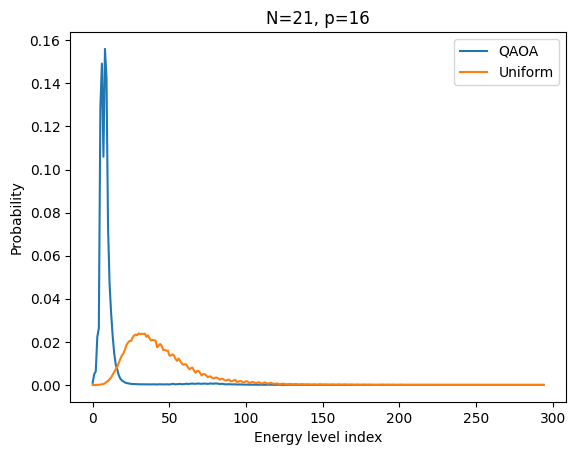

In [58]:
plot_probabilities_by_energy_level(21, 16, df_mf.rename(columns={"overlap": "overlap transferred"}))

In [54]:
df_o = pd.read_json('../qokit/assets/best_known_QAOA_parameters_wrt_overlap.json', orient='index')

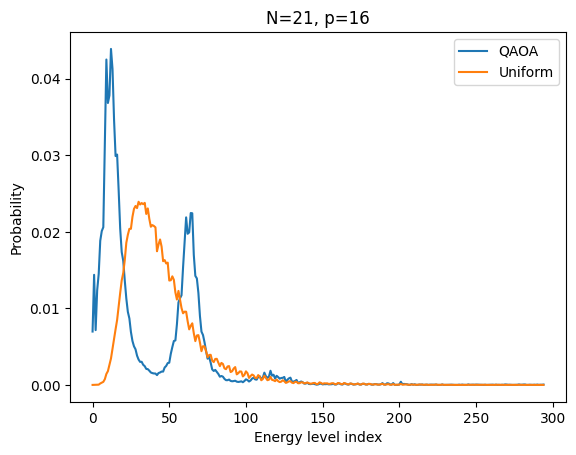

In [56]:
plot_probabilities_by_energy_level(21, 16, df_o.rename(columns={"overlap": "overlap transferred"}))

## Intermediate distributions

In [100]:
p_max = 27

# convert to desired format
rows = []

for N in range(20,34):
    df_suffix = "_overlap"

    outpath = f"../scripts/data/0221_intermediate_for_transferred_mean_overlap_0217_{N}_{p_max}.pickle"
    if not Path(outpath).exists():
        continue

    res = pickle.load(open(outpath, "rb"))
    for p in range(1, p_max+1):
        rows.append(
            {
                "N" : N,
                "p" : p,
                "beta" : res["beta"][:p],
                "gamma" : res["gamma"][:p],
                "overlap transferred" : res["overlaps"][p-1],
                "merit factor transferred" : res["merit_factors"][p-1],
            }
        )
    
df_intermed = pd.DataFrame(rows, columns=rows[0].keys())

## We can quantify the notion of "going slow" vs "going fast" by looking at how much the output distribution changes

In [101]:
N = 20

row = df_intermed[(df_intermed["N"] == N) & (df_intermed["p"] == 1)].squeeze()
sv_prev = probabilities_from_beta_gamma(row["N"], row["beta"], row["gamma"])

tvds = []

for p in range(2, p_max+1):
    row = df_intermed[(df_intermed["N"] == N) & (df_intermed["p"] == p)].squeeze()

    sv_curr = probabilities_from_beta_gamma(row["N"], row["beta"], row["gamma"])

    tvd = 0.5*sum(np.abs(sv_curr-sv_prev))
    print(p, tvd)
    tvds.append(tvd)
    sv_prev = copy.deepcopy(sv_curr)

2 0.21096893915001683
3 0.15500740775957128
4 0.13527206812130266
5 0.13065531982519507
6 0.12674159908371968
7 0.12513092763200528
8 0.1259273875696235
9 0.1286840862803283
10 0.13069203482848596
11 0.13346933043896653
12 0.136272254759898
13 0.13690585672703723
14 0.14007232491617025
15 0.14373047499018618
16 0.14703440596590286
17 0.1474936958641391
18 0.14903568583755591
19 0.15133525223727143
20 0.1544424862942567
21 0.15978600148252403
22 0.16411018088538512
23 0.16983653459249526
24 0.17310564711116602
25 0.18604809510926268
26 0.20580090166802928
27 0.1697691332278737


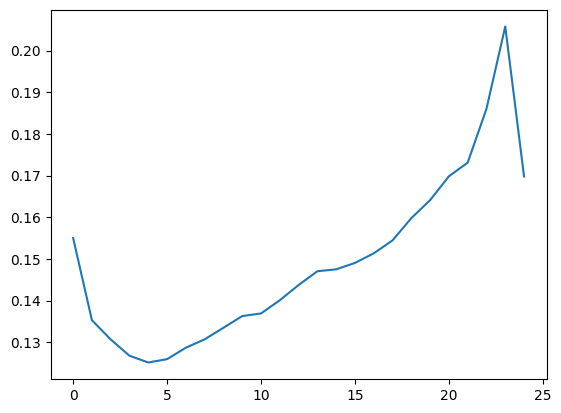

In [102]:
plt.plot(tvds[1:])

Overlap with top 10: 0.028956679809784454


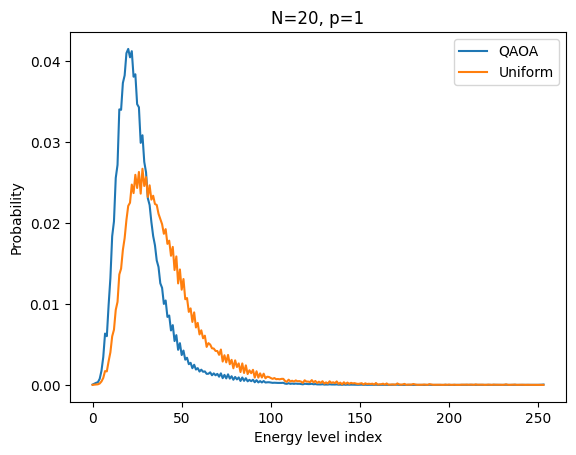

Overlap with top 10: 0.07210246512282155


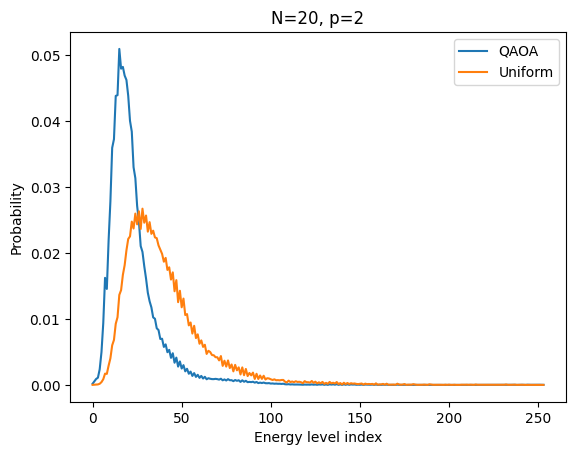

Overlap with top 10: 0.12195781574034578


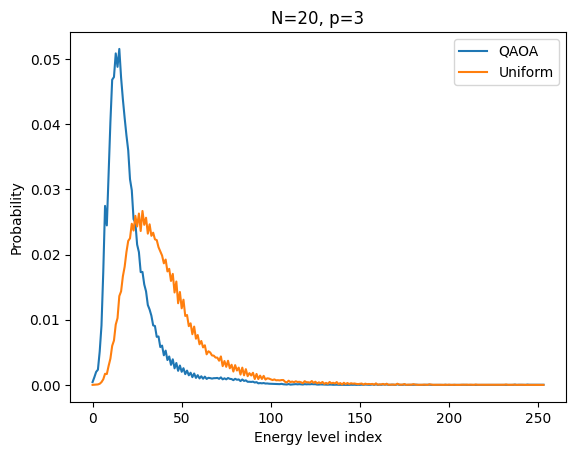

Overlap with top 10: 0.16422277757143444


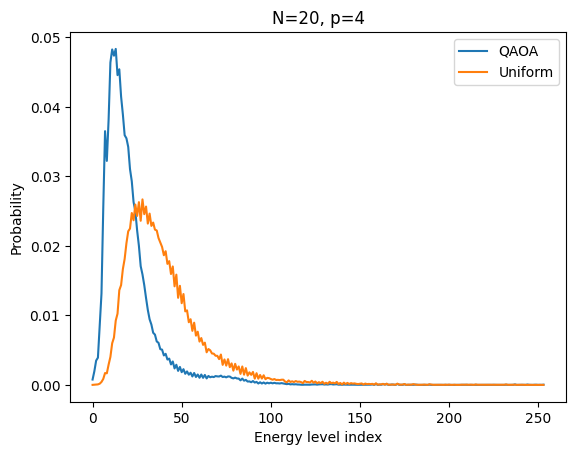

Overlap with top 10: 0.19426719299647935


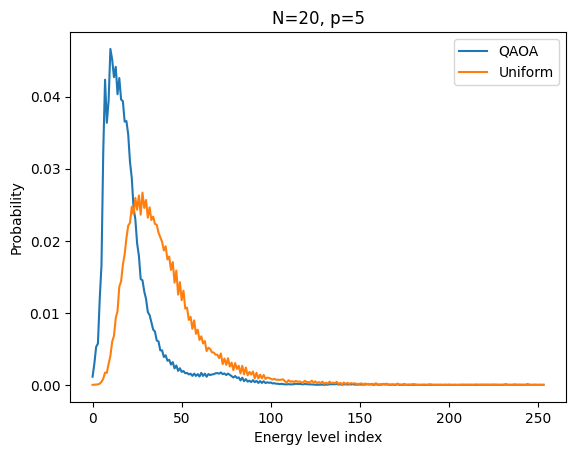

Overlap with top 10: 0.21292167659399955


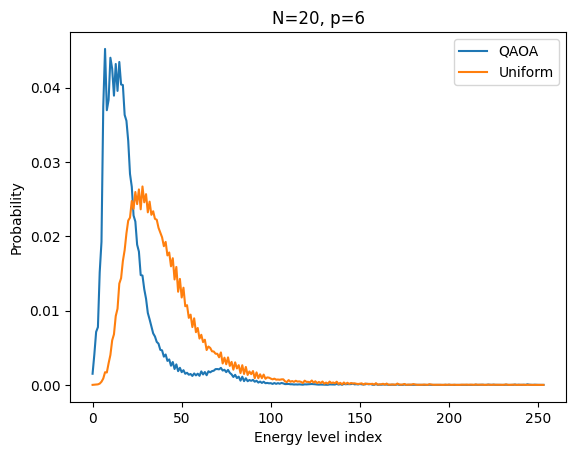

Overlap with top 10: 0.2210447069519325


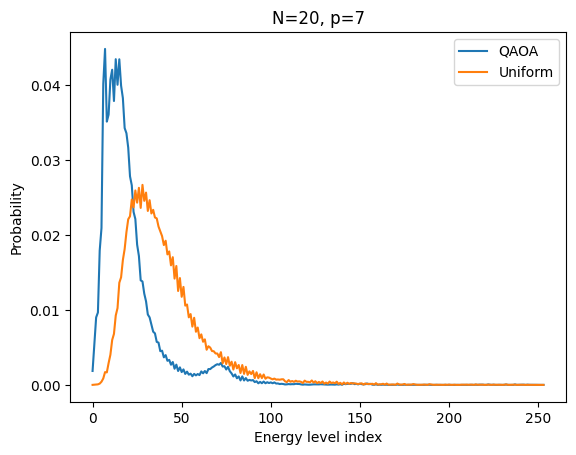

Overlap with top 10: 0.22347916424568015


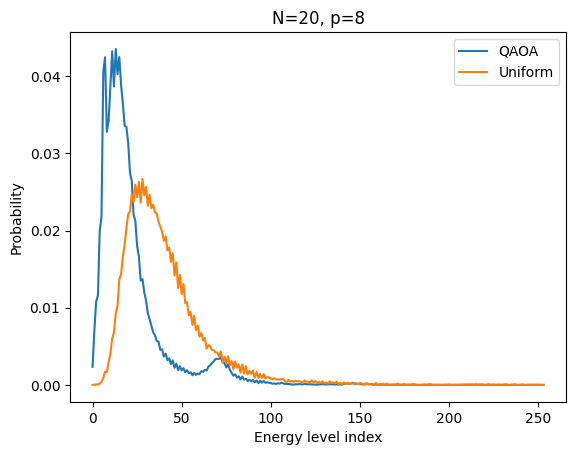

Overlap with top 10: 0.22228474160210418


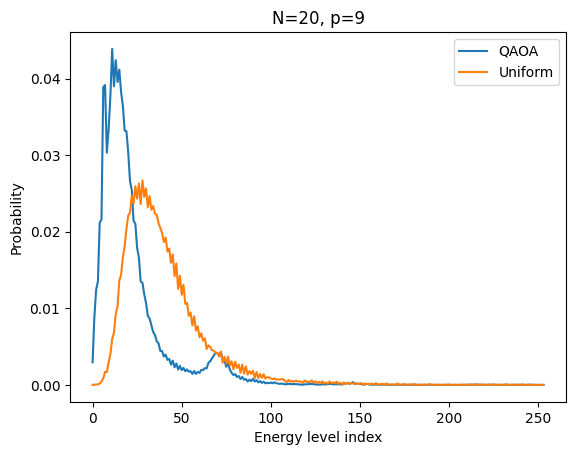

Overlap with top 10: 0.22029282542104


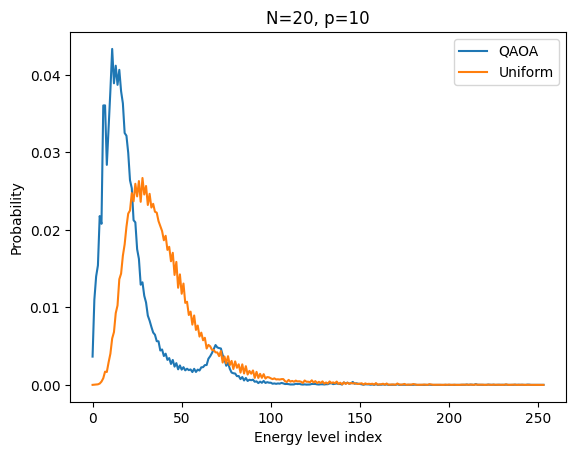

Overlap with top 10: 0.21776024872590222


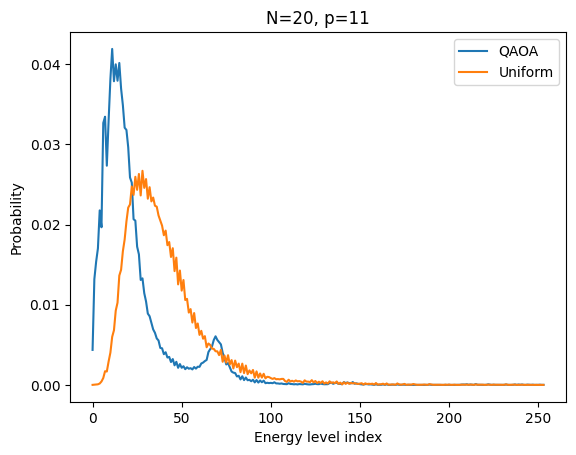

Overlap with top 10: 0.21622404188437777


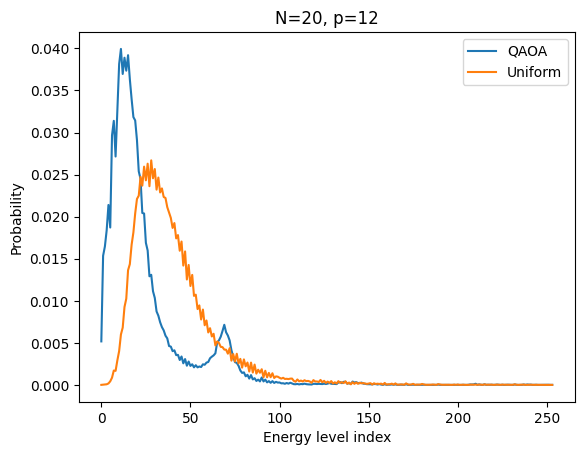

Overlap with top 10: 0.21429654188010228


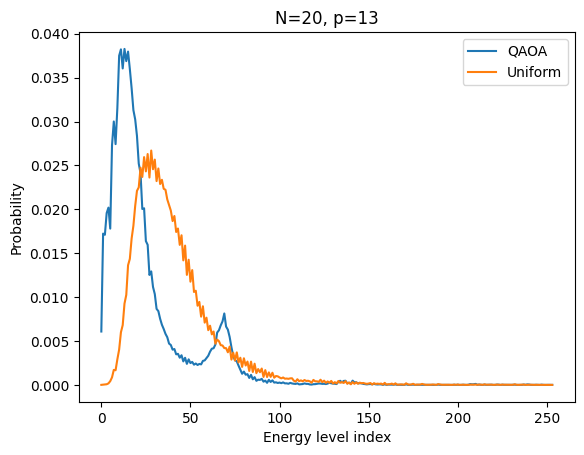

Overlap with top 10: 0.21258568942100306


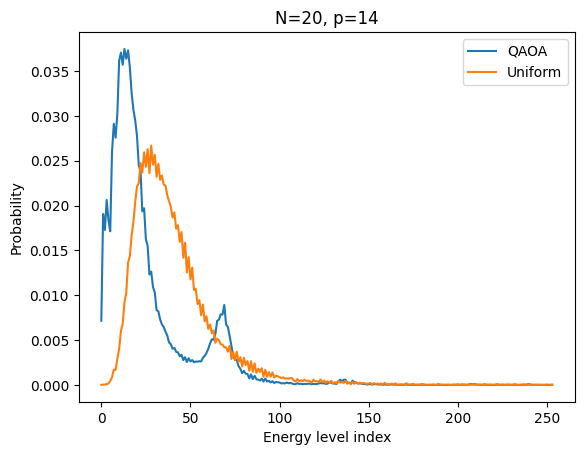

Overlap with top 10: 0.21036228940319107


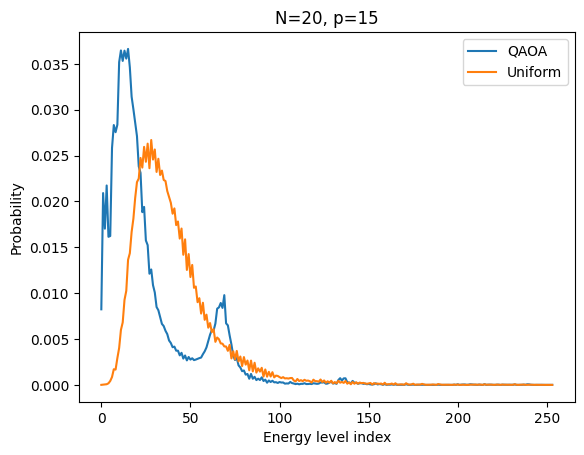

Overlap with top 10: 0.20714606088746576


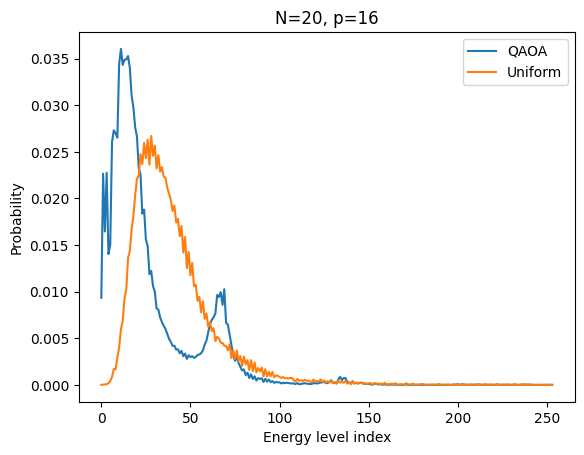

Overlap with top 10: 0.20370343134169314


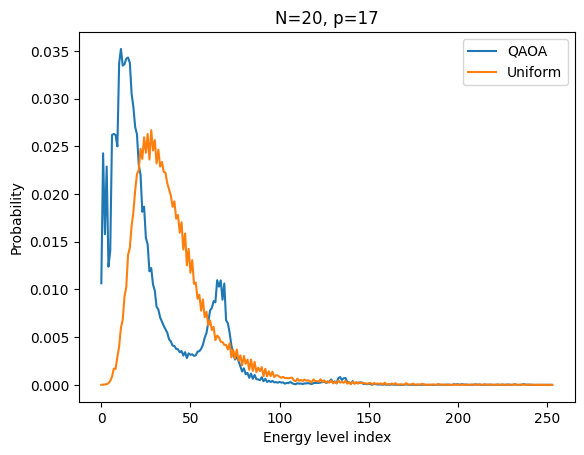

Overlap with top 10: 0.20117751218783336


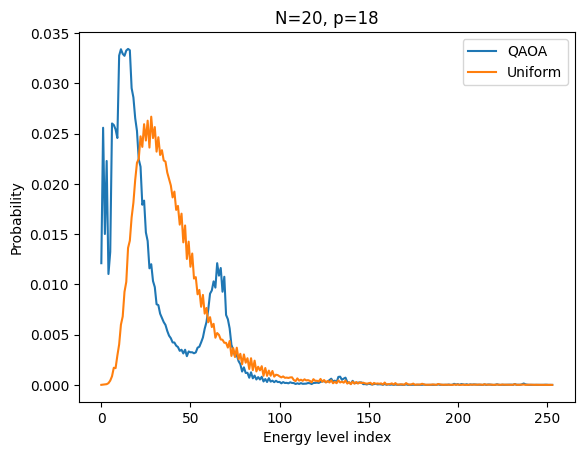

Overlap with top 10: 0.19865672755723765


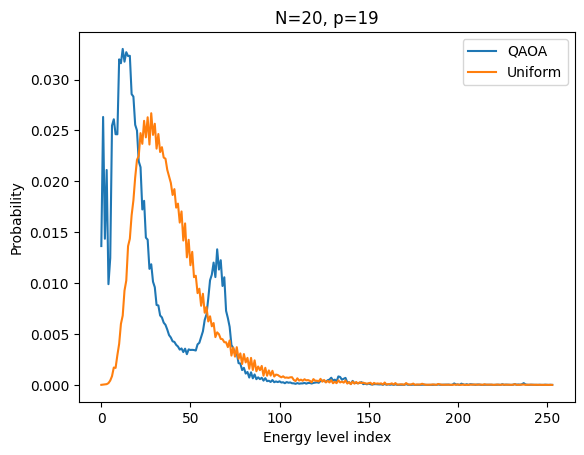

Overlap with top 10: 0.1964640165676543


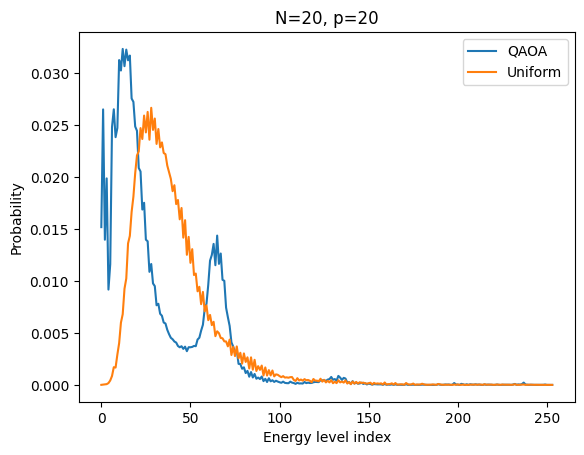

Overlap with top 10: 0.19253407152021976


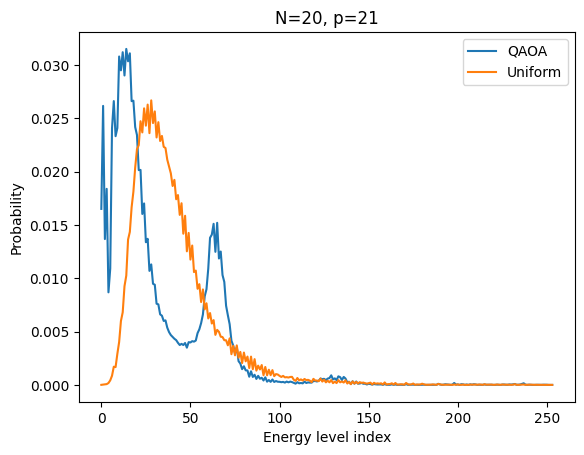

Overlap with top 10: 0.18858639678102135


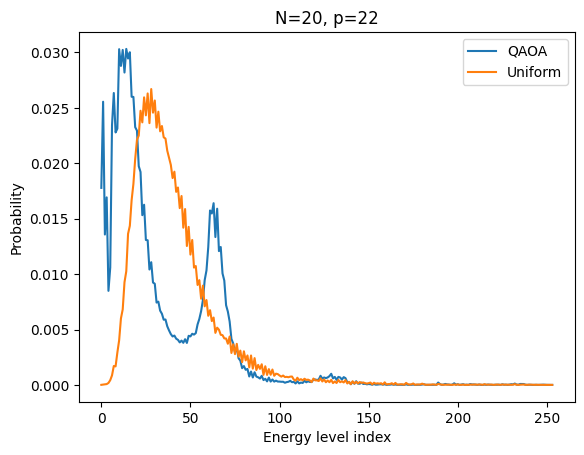

Overlap with top 10: 0.18738285767612278


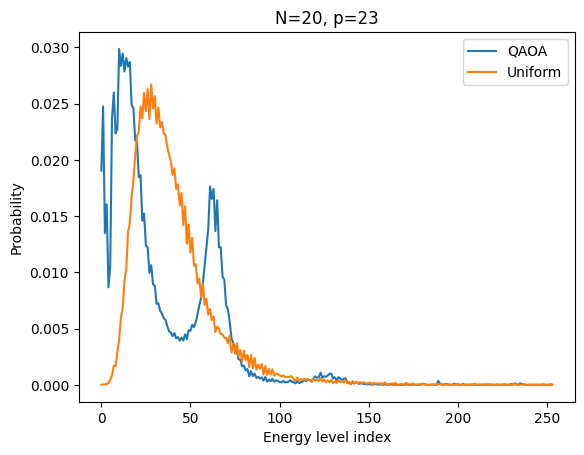

Overlap with top 10: 0.1933013154855234


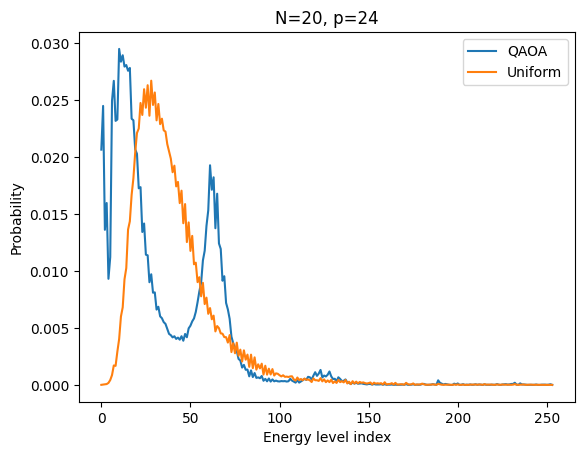

Overlap with top 10: 0.21233473992345758


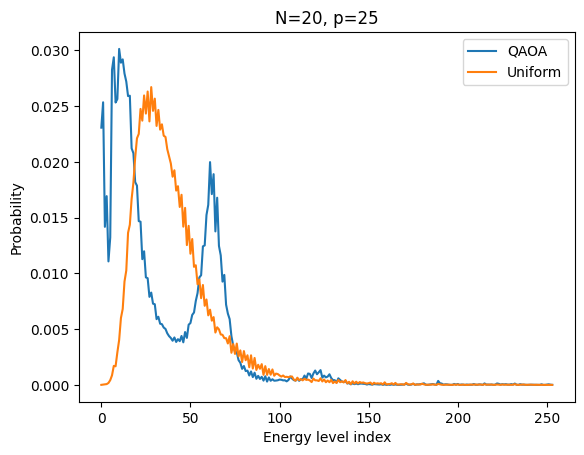

Overlap with top 10: 0.2663789557790957


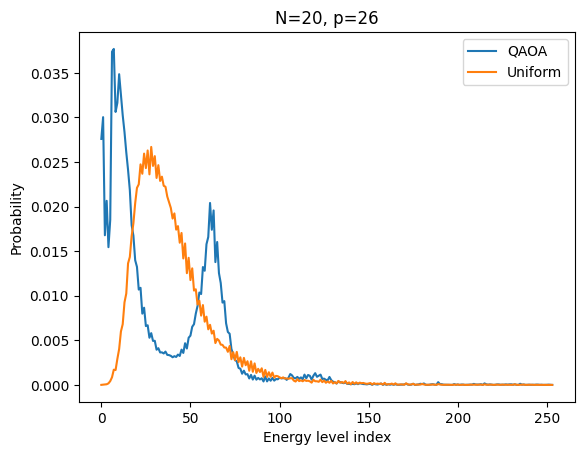

Overlap with top 10: 0.3419644453505589


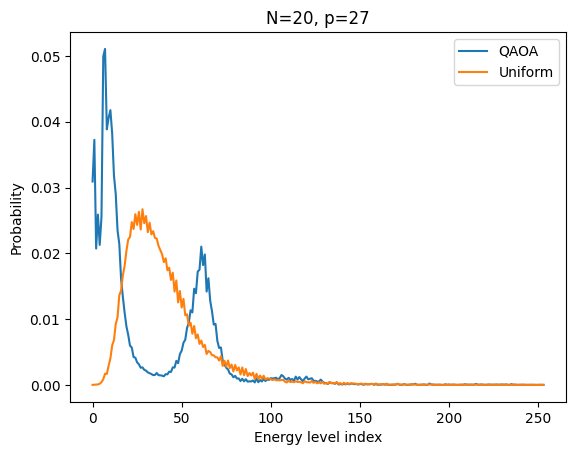

In [92]:
N = 20

for p in range(1, p_max+1):
    plot_probabilities_by_energy_level(N, p, df_intermed)

## Simple sampler

In [73]:
def statevector_from_beta_gamma(N, beta, gamma):
    _, offset = get_energy_term_indices(N)
    precomputed_energies_vectorized = -(N**2) / (2 * get_precomputed_labs_merit_factors(N)) - offset
    sim = QAOAFURXSimulatorC(N, precomputed_energies_vectorized)
    sv = sim.simulate_qaoa(gamma, beta)
    return sv.get_complex()

row = df[(df["N"] == 20) & (df["p"] == 16)].squeeze()
sv = statevector_from_beta_gamma(row["N"], row["beta"], row["gamma"])

In [74]:
from qiskit.quantum_info import Statevector

sv2 = Statevector(sv)

In [ ]:
### Qiskit is possibly too slow

In [ ]:
counts = sv2.sample_counts(10)

In [ ]:
counts